In [1]:
import pandas as pd, numpy as np, cPickle as pkl 
import sys, os 
sys.path.append('../dataprep/') 
sys.path.append('../models/') 
from QueryFunctions import * 
import tensorflow as tf 

In [2]:
use_query = 0 ### turn this switch on (to 1.0/True vs 0.0/False) to run query using QueryRunner 

if use_query: 
    from queryrunner_client import Client 
    qr = Client(user_email='will.zou@uber.com') 
    label_dates_weekly = "'2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04'" 
    city_ids = '1,5,6,8,10,12,20,23,198' 
    feature_dates="'2019-06-30'" 
    proposal_start_date = '2019-07-08' 

    predFrame2 = qr.execute('presto', rxgy_data_sapphire_presto_featuremod2(label_dates_weekly, feature_dates,  city_ids)) 
    predFrame2 = pd.DataFrame(predFrame2.load_data()) 
else: 
    predFrame2 = pd.read_csv('../data/rxgy_adrm_train_multimetric_US_20190602_20190804_simulated.csv') 

""" 
label_dates_weekly = "'2019-07-07','2019-06-30','2019-06-23','2019-06-16'"
city_ids = '1,5,6,8,10,12,20,23,198' 
feature_dates="'2019-06-02'" 
proposal_start_date = '2019-06-10' 

predFrame = qr.execute('presto', rxgy_data_sapphire_presto_featuremod2(label_dates_weekly, feature_dates,  city_ids)) 
predFrame = pd.DataFrame(predFrame.load_data()) 
""" 

""" 
label_dates_weekly = "'2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01'" 
city_ids = '1,5,6,8,10,12,20,23,198' 
feature_dates="'2019-07-28'" 
proposal_start_date = '2019-08-05' 

predFrame3 = qr.execute('presto', rxgy_data_sapphire_presto_featuremod2(label_dates_weekly, feature_dates,  city_ids)) 
predFrame3 = pd.DataFrame(predFrame3.load_data()) 
""" 

"""
label_dates_weekly = "'2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27'" 
city_ids = '1,5,6,8,10,12,20,23,198' 
feature_dates="'2019-09-22'" 
proposal_start_date = '2019-09-30' 

predFrame4 = qr.execute('presto', rxgy_data_sapphire_presto_featuremod2(label_dates_weekly, feature_dates,  city_ids)) 
predFrame4 = pd.DataFrame(predFrame4.load_data()) 
""" 


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (9,10,11,12,14,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'\nlabel_dates_weekly = "\'2019-10-06\', \'2019-10-13\', \'2019-10-20\', \'2019-10-27\'" \ncity_ids = \'1,5,6,8,10,12,20,23,198\' \nfeature_dates="\'2019-09-22\'" \nproposal_start_date = \'2019-09-30\' \n\npredFrame4 = qr.execute(\'presto\', rxgy_data_sapphire_presto_featuremod2(label_dates_weekly, feature_dates,  city_ids)) \npredFrame4 = pd.DataFrame(predFrame4.load_data()) \n'

In [3]:
cohort_column_name = 'cohort' 
treatment_indicator_value = 'treatment' 
control_indicator_value = 'control' 

print(len(predFrame2))
print(sum(predFrame2[cohort_column_name] == control_indicator_value))


1972139
395281


In [4]:
### preprocess the data 
### -- sample treatment to match control cohort 
### -- eliminate nulls, standard normalization 

D = predFrame2 
D = D.sample(frac=0.3) 

feature_list = [ 
    'rating_2driver_min_avg_84d'
    , 'trip_incomplete_total_84d'
    , 'days_active_84d'
    , 'days_since_trip_first_lifetime'
    , 'days_since_last_hard_churn_lifetime'
    , 'days_since_last_soft_churn_lifetime'
    , 'fare_max_sd_84d'
    , 'churns_hard_lifetime'
    , 'trips_lifetime'
    , 'fare_max_p50_84d'
    , 'duration_session_pre_request_max_p50_84d'
    , 'trip_pool_per_x_84d'
    , 'fare_total_win7d_sd_84d'
    , 'trip_complete_win7d_sd_84d'
    , 'session_per_days_active_84d'
    , 'churns_soft_lifetime'
    , 'trip_complete_per_days_active_84d'
    , 'trip_pool_prc_84d'
    , 'session_background_pre_request_prc_84d'
    , 'session_lt_1m_prc_84d'
    , 'session_request_prc_84d'
    , 'duration_session_outside_total_prc_84d'
    , 'trip_x_prc_84d'
    , 'days_since_trip_last_lifetime'
    , 'promo_used_84d'
    , 'has_session_request_84d'
    , 'has_session_without_request_84d' 
    , 'fare_promo_total_avg_84d', 
    'fare_total_avg_84d', 
    'surge_trip_avg_84d', 
    'fare_total_win7d_potential_84d', 
    'fare_total_win28d_potential_84d', 
    'fare_lifetime', 
    'time_to_first_message_minutes_mean_lifetime', 
    'ata_trip_max_avg_84d', 
    'eta_trip_max_avg_84d', 
    'trip_pool_matched_avg_84d', 
    'payment_cash_trip_total_84d', 
    'duration_trip_total_p50_84d'
] 

label_list = [ 
    'label_trip_28d', 
    'label_vc_28d' 
] 

for l in feature_list: 
    print('number of nans: ' + str(sum(D[l] == '\N'))) 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l] = D[l] - D[l].mean() 
    D[l] = D[l] / D[l].std() 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

for l in label_list: 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

### -- compute simple statistics 
### compute cpit 
treated_entries = D[D[cohort_column_name] == treatment_indicator_value] 
untreated_entries = D[D[cohort_column_name] == control_indicator_value] 

rpu_treated = float(treated_entries[label_list[0]].sum()) / len(treated_entries) 
nipu_treated = float(treated_entries[label_list[1]].sum()) / len(treated_entries) 

rpu_untreated = float(untreated_entries[label_list[0]].sum()) / len(untreated_entries) 
nipu_untreated = float(untreated_entries[label_list[1]].sum()) / len(untreated_entries) 

cpit = -1.0 * (nipu_treated - nipu_untreated) / (rpu_treated - rpu_untreated) 

print('rpu_treated : ' + str(rpu_treated)) 
print('nipu_treated : ' + str(nipu_treated)) 
print('rpu_untreated : ' + str(rpu_untreated)) 
print('nipu_untreated : ' + str(nipu_untreated)) 
print('cpit : ' + str(cpit)) 

### split the data into 3/1/1 train/val/test 
len_tr = len(D) / 5 * 3 
len_va = len(D) / 5 

nX = D[feature_list].as_matrix() 
w = D[cohort_column_name].apply(lambda x: 1.0 if x == treatment_indicator_value else 0.0) 
w = w.as_matrix() 
values = D[label_list[0]] 
values = values.as_matrix() * 1.0 
negcost = D[label_list[1]] 
negcost = negcost.as_matrix() * 1.0 

## split train/val/test sets 

nX_tr = nX[0:len_tr, :] 
nX_va = nX[len_tr:len_tr + len_va, :] 
nX_te = nX[len_tr + len_va:, :] 

w_tr = w[0:len_tr]
w_va = w[len_tr:len_tr + len_va] 
w_te = w[len_tr + len_va:] 

values_tr = values[0:len_tr] 
values_va = values[len_tr:len_tr + len_va] 
values_te = values[len_tr + len_va:] 

negcost_tr = negcost[0:len_tr] 

negcost_va = negcost[len_tr:len_tr + len_va] 

negcost_te = negcost[len_tr + len_va:] 

## saving data using cPickel and naming the dictionaries 
saveD = {'nX_tr':nX_tr, 
         'w_tr':w_tr, 
         'values_tr':values_tr, 
         'nX_va':nX_va, 
         'w_va':w_va, 
         'values_va':values_va, 
         'nX_te':nX_te, 
         'w_te':w_te, 
         'values_te':values_te, 
         'feature_list':feature_list, 
         #'avg_ni_usd_tr':avg_ni_usd_tr, 
         'negcost_tr': negcost_tr, 
         #'avg_ni_usd_va':avg_ni_usd_va, 
         'negcost_va': negcost_va, 
         #'avg_ni_usd_te':avg_ni_usd_te, 
         'negcost_te': negcost_te 
         } 

pkl.dump(saveD, open('../data/rxgy_ma_training_data_v5_2019_07_08_vc_tr_featuremod3', 'w')) 


number of nans: 128837


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 45
number of nans: 45
number of nans: 1
number of nans: 45
number of nans: 0
number of nans: 1
number of nans: 40305
number of nans: 56877
number of nans: 0
number of nans: 0
number of nans: 15250
number of nans: 45
number of nans: 15250
number of nans: 15250
number of nans: 15250
number of nans: 15250
number of nans: 15250
number of nans: 15250
number of nans: 15250
number of nans: 0
number of nans: 15250
number of nans: 15250
number of nans: 15250


KeyError: 'fare_promo_total_avg_84d'

In [5]:
### code implements ranking model for treatment effect 
### for optimizing with respect to direct marketplace objectives 
### using tensorflow 

import numpy as np, tensorflow as tf, pandas as pd, pickle as pkl 
sys.path.append('../')  
from ModelDefinitions import * 
from DataProcFunctions import * 

### RxGy TQR setting: 
p_quantile = 0.4 ## percentage of quantile to aim for 
num_optimize_iterations = 1800 ## number of optimization iterations 
num_modeling_inits = 2 ## number of random initializations 
num_hidden = 0 ## number of hidden units in DNN 
use_schedule = True ## option to use a constraint annealing schedule 
temp = 0.5 ## initial temperature for constraints 
inc_temp = 0.1 ## increment of temperature per 100 iterations 
save_cf_data = False ### whether to save data for causal forest training 

## set a random seed to reproduce results 
seed = 1234; tf.compat.v2.random.set_seed(seed); np.random.seed(seed) 

sample_frac = 1.0 ## option to sample data by a fraction \in (0, 1) 
data_filename =  '../data/rxgy_ma_training_data_v5_2019_07_08_vc_tr_featuremod3' 
prefix = 'rxgy_v5_07_08_featuremod3_tr_iter100_run4' 

D_tre, D_unt, Dv_tre, Dv_unt, Dt_tre, Dt_unt, o_tre, o_unt, ov_tre, ov_unt, ot_tre, ot_unt, c_tre, c_unt, cv_tre, cv_unt, ct_tre, ct_unt, D, w, o, c, Dv, wv, ov, cv, Dt, wt, ot, ct = LoadDataFromPkl(data_filename, frac = sample_frac, save_cf_data=save_cf_data) 

print('### ----- start the training of deep learning models ------ ') 
gs_tqr = [] 
gs_drm = [] 
for i in range(num_modeling_inits): 
    gs_tqr.append(tf.Graph()) 
for i in range(num_modeling_inits): 
    gs_drm.append(tf.Graph()) 

print('------> Training TQR ranking model .... ') 
val_results = [] 
sess_list = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    obj, opt, dumh, dumhu, vtemp, p_quantile = TunableTQRankingModelDNN(gs_tqr[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first', temp, p_quantile, num_hidden, use_schedule) 
    ### session definitions and variable initialization 
    sess = tf.Session(graph = gs_tqr[i]) 
    sess_list.append(sess) 
    
    ### initialize variables and run optimization 
    with gs_tqr[i].as_default() as g: 
        init = tf.global_variables_initializer() 
    sess.run(init) 
    cur_temp = temp 
    for step in range(num_optimize_iterations): 
        _, objres = sess.run([opt, obj]) 
        if step % 100 == 0: 
            cur_temp = cur_temp + inc_temp 
            print('opt. step : ' + str(step) + ' obj: ' + str(objres)) 
            if use_schedule: 
                sess.run(vtemp.assign(cur_temp))
                print('setting temperature to :' + str(sess.run(vtemp))) 
    
    print('---> optimization finished ... ') 
    tempvalue = sess.run(vtemp)
    p_quantilevalue = p_quantile
    print('temp:') 
    print(tempvalue)
    print('p_quantile:')
    print(p_quantilevalue) 
    
    ### evaluate CPIT metric on validation set 
    objv, dumo, dumh, dumhu, dvtemp, dp_quantile = TunableTQRankingModelDNN(gs_tqr[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', temp, p_quantile, num_hidden, use_schedule) 
    
    val_result = sess.run(objv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

from operator import itemgetter 
best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_tqr[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("tqrhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    tqrscore = sess_list[best_index].run(h_test) 

print('------> Training DRM ranking model .... ') 
sess_list = [] 
val_results = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    ### ---- train cpit ranking model for comparison --- 
    dobjc, doptc, ddumh, ddumu = DirectRankingModelDNN(gs_drm[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first-drm', num_hidden) 
    
    dsess = tf.Session(graph = gs_drm[i]) 
    sess_list.append(dsess) 
    
    ### initialize variables and run optimization 
    with gs_drm[i].as_default() as g: 
        dinit = tf.global_variables_initializer() 
    dsess.run(dinit) 
    for step in range(num_optimize_iterations): 
        _, dobjres = dsess.run([doptc, dobjc]) 
        if step % 100 == 0: 
            print('opt. step : ' + str(step) + ' obj: ' + str(dobjres)) 
    
    print('---> optimization finished ... ') 
    
    ### evaluate CPIT metric on validation set 
    dobjv, ddumo, dumh, dumhu = DirectRankingModelDNN(gs_drm[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', num_hidden)
    val_result = dsess.run(dobjv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_drm[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("drmhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    drmscore = sess_list[best_index].run(h_test) 

### ---- train hte model for comparison ---- 
### we could utimize the original HTE functions 
from LinearHTEModels import * 
from PromotionModels import PromotionModels 

pmodels = PromotionModels() 

## set-up RLearner 
rl_ridge_model_O, rl_ridge_model_C = pmodels.fit_rlearner(D, o, c, w) 

## one model for order lift and one model for cost drop 
pred_values_va_rlearner_O = rl_ridge_model_O.predict(Dt) 
pred_values_va_rlearner_C = rl_ridge_model_C.predict(Dt) 

#if ranking_model == 'effectiveness-ratio': ## if we use the effectiveness ratio model, compute effectiveness ratio 
pred_values_va_rlearner = np.divide(np.maximum(pred_values_va_rlearner_O, 0), pred_values_va_rlearner_C + 1e-7) 

lhmodels = LinearHTEModels() 


load data from ../data/rxgy_ma_training_data_v5_2019_07_08_vc_tr_featuremod3
printing averages of c_tr, c_unt, o_tre, o_unt ... :
0.17914820257318836
0.06158097484449673
0.05130641330166271
0.02673917969635169
### ----- start the training of deep learning models ------ 
------> Training TQR ranking model .... 
---> running cross validation, iteration: 0



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



opt. step : 0 obj: 4.753091339673534
setting temperature to :0.6
opt. step : 100 obj: 4.717418246350326
setting temperature to :0.7
opt. step : 200 obj: 4.683181262910153
setting temperature to :0.7999999999999999
opt. step : 300 obj: 4.642134264259395
setting temperature to

opt. step : 0 obj: 4.777006033990844
setting temperature to :0.6
opt. step : 100 obj: 4.729566344289665
setting temperature to :0.7
opt. step : 200 obj: 4.692250223827163
setting temperature to :0.7999999999999999
opt. step : 300 obj: 4.660730084265286
setting temperature to :0.8999999999999999
opt. step : 400 obj: 4.631737480902887
setting temperature to :0.9999999999999999
opt. step : 500 obj: 4.603055479208876
setting temperature to :1.0999999999999999
opt. step : 600 obj: 4.570004434493083
setting temperature to :1.2
opt. step : 700 obj: 4.530627795136798
setting temperature to :1.3
opt. step : 800 obj: 4.498307968720447
setting temperature to :1.4000000000000001
opt. step : 900 obj: 4.474258956248882
setting temperature to :1.5000000000000002
opt. step : 1000 obj: 4.456635874998921
setting temperature to :1.6000000000000003
opt. step : 1100 obj: 4.442322313876678
setting temperature to :1.7000000000000004
opt. step : 1200 obj: 4.429864514267671
setting temperature to :1.8000000000

validation CPIT:
5.4456332429454575
---> running cross validation, iteration: 1
opt. step : 0 obj: 4.81216244583293
opt. step : 100 obj: 4.64704663184805
opt. step : 200 obj: 4.468202764974882
opt. step : 300 obj: 4.33749157041729
opt. step : 400 obj: 4.249294839118934
opt. step : 500 obj: 4.202323537438153
opt. step : 600 obj: 4.165646763440499
opt. step : 700 obj: 4.137054158393313
opt. step : 800 obj: 4.113647600107275
opt. step : 900 obj: 4.093020027648886
opt. step : 1000 obj: 4.073648508131135
opt. step : 1100 obj: 4.054384981216349
opt. step : 1200 obj: 4.036074063959198
opt. step : 1300 obj: 4.019067281309364
opt. step : 1400 obj: 4.003902887113532
opt. step : 1500 obj: 3.9905234557505325
opt. step : 1600 obj: 3.9785363243072243
opt. step : 1700 obj: 3.9676174771565162
---> optimization finished ... 
validation CPIT:
5.235777605146764
best performing model: iteration 1


rpu_control: 0.024955679803627437
nipu_control: -0.06613553318209264
rpu_ft: 0.05033382262417728
nipu_ft: -0.18239633989525222
---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 0.05
treated_target_nipu: -0.19
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.05
treated_nontarget_nipu: -0.18
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.07
--- with 9.998144626374136% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 5.672684217026611
--> in non-targeted users: 
cpit = 4.480213268568984
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.03
nipu_cohort: -0.08
lift targeted cohort vs control: 0.09
lift random vs control: 1.02
cpit cohort vs control: 5.66
lift targeted-treated vs control: 1.08
cpit cohort: 5.658541
---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 0.05
treated_target_nipu: -0.18
nontreated_ta

---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 0.08
treated_target_nipu: -0.29
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.16
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.07
--- with 19.996289252748273% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.493287397645291
--> in non-targeted users: 
cpit = 4.636174637174749
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.03
nipu_cohort: -0.11
lift targeted cohort vs control: 0.40
lift random vs control: 1.02
cpit cohort vs control: 4.49
lift targeted-treated vs control: 2.17
cpit cohort: 4.494366
---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 0.07
treated_target_nipu: -0.25
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.15
nontreated_nontarget_rp

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 0.03
treated_target_nipu: -0.11
nontreated_target_rpu: 0.02
nontreated_target_nipu: -0.05
treated_nontarget_rpu: 0.06
treated_nontarget_nipu: -0.21
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.07
--- with 29.994433879122408% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.515589166523719
--> in non-targeted users: 
cpit = 4.600964368420093
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.03
nipu_cohort: -0.08
lift targeted cohort vs control: 0.15
lift random vs control: 1.02
cpit cohort vs control: 4.49
lift targeted-treated vs control: 0.29
cpit cohort: 4.490612
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 0.04
treated_target_nipu: -0.12
nontreated_target_rpu: 0.02
nontreated_target_nipu: -0.06
treated_nontarget_rpu: 0.06
treated_nontarget_nipu: -0.22
nontreated_nontarget_rp

---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 0.07
treated_target_nipu: -0.24
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.14
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.06
--- with 39.992578505496546% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.0004839342664855
--> in non-targeted users: 
cpit = 5.677076082741575
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.04
nipu_cohort: -0.13
lift targeted cohort vs control: 0.66
lift random vs control: 1.02
cpit cohort vs control: 4.00
lift targeted-treated vs control: 1.71
cpit cohort: 4.001120
---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 0.06
treated_target_nipu: -0.24
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.13
nontreated_nontarget_r

---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 0.07
treated_target_nipu: -0.24
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.13
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.05
--- with 49.99072313187068% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.33865856124426
--> in non-targeted users: 
cpit = 5.208222730142692
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.04
nipu_cohort: -0.14
lift targeted cohort vs control: 0.73
lift random vs control: 1.02
cpit cohort vs control: 4.34
lift targeted-treated vs control: 1.61
cpit cohort: 4.337748
---------------------------->>>>>>
perc - target: 0.60
treated_target_rpu: 0.06
treated_target_nipu: -0.23
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.12
nontreated_nontarget_rpu:

---------------------------->>>>>>
perc - target: 0.60
treated_target_rpu: 0.06
treated_target_nipu: -0.23
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.12
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.05
--- with 59.988867758244815% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.422296056385127
--> in non-targeted users: 
cpit = 5.291849091902323
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.05
nipu_cohort: -0.16
lift targeted cohort vs control: 0.82
lift random vs control: 1.02
cpit cohort vs control: 4.42
lift targeted-treated vs control: 1.47
cpit cohort: 4.421341
---------------------------->>>>>>
perc - target: 0.70
treated_target_rpu: 0.06
treated_target_nipu: -0.21
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.11
nontreated_nontarget_rp

---------------------------->>>>>>
perc - target: 0.70
treated_target_rpu: 0.06
treated_target_nipu: -0.21
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.08
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.11
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.04
--- with 69.98701238461895% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.472806213165054
--> in non-targeted users: 
cpit = 5.175797790534578
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.05
nipu_cohort: -0.16
lift targeted cohort vs control: 0.85
lift random vs control: 1.02
cpit cohort vs control: 4.47
lift targeted-treated vs control: 1.30
cpit cohort: 4.472988
---------------------------->>>>>>
perc - target: 0.80
treated_target_rpu: 0.05
treated_target_nipu: -0.20
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.10
nontreated_nontarget_rpu

---------------------------->>>>>>
perc - target: 0.80
treated_target_rpu: 0.05
treated_target_nipu: -0.19
nontreated_target_rpu: 0.02
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.15
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.06
--- with 79.98515701099309% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.301320895382538
--> in non-targeted users: 
cpit = 7.212561682526695
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.05
nipu_cohort: -0.16
lift targeted cohort vs control: 0.92
lift random vs control: 1.02
cpit cohort vs control: 4.30
lift targeted-treated vs control: 1.12
cpit cohort: 4.301167
---------------------------->>>>>>
perc - target: 0.90
treated_target_rpu: 0.05
treated_target_nipu: -0.19
nontreated_target_rpu: 0.02
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.11
nontreated_nontarget_rpu

---------------------------->>>>>>
perc - target: 0.90
treated_target_rpu: 0.05
treated_target_nipu: -0.18
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.07
treated_nontarget_rpu: 0.05
treated_nontarget_nipu: -0.19
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.03
--- with 89.98330163736723% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 4.381111510555743
--> in non-targeted users: 
cpit = 6.358499827903526
rpu_control: 0.02
nipu_control: -0.07
rpu_ft: 0.05
nipu_ft: -0.18
rpu_cohort: 0.05
nipu_cohort: -0.17
lift targeted cohort vs control: 0.91
lift random vs control: 1.02
cpit cohort vs control: 4.38
lift targeted-treated vs control: 1.02
cpit cohort: 4.383035
rpu_cohort
0.047781131632358045
treated_target_rpu
0.050343357802510064
---------------------------->>>>>>
perc - target: 1.00
treated_target_rpu: 0.05
treated_target_nipu: -0.18
nontreated_target_rpu: 0.02
nontreated_target_nipu: -0.07
treated_no

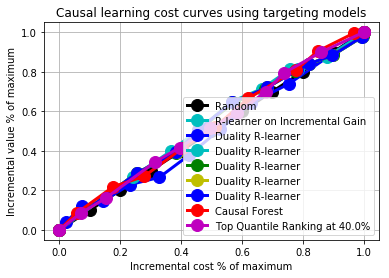

In [7]:
lhmodels = LinearHTEModels() 
lambds = [1.0, 0.1, 0.01, 0.001, 0.0001] 
rlearnerscores = [] 
rl_ridge_model_L_list = [] 
## set-up lagrangian rlearner 
for i in range(len(lambds)): 
    lambd = lambds[i] 
    rl_ridge_model_L = lhmodels.fit_rlearner_lagrangian(D, o, c, w, lambd) 
    rl_ridge_model_L_list.append(rl_ridge_model_L) 
    rlearnerscores.append(rl_ridge_model_L.predict(Dt)) 

""" 
### this section is to load the results trained by grf R code 
### 

ot_cf = pd.read_csv('../results/causal_forest_grf_test_set_results_O_finalsize_numtrees1002.csv') 
ct_cf = pd.read_csv('../results/causal_forest_grf_test_set_results_C_finalsize_numtrees1002.csv') 

ot_cf = ot_cf.as_matrix() 
Ocfscores = ot_cf[0] 

ct_cf = ct_cf.as_matrix() 
Ccfscores = ct_cf[0] 

cfscore = np.divide(Ocfscores, Ccfscores) 
""" 

### ---- experimentation and plotting cost-curves ----- 
from experimentation import * 
exp = Experimentation() 
ranscore = np.random.rand(ot.shape[0], ) 
colors = ['b', 'c', 'g', 'y', 'b', 'c', 'g', 'y', 'b', 'c', 'g', 'y', 'b', 'c', 'g', 'y'] 
plt.figure() 
rlearnerauccs = [] 
ranaucc = exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ot, wt, -1.0 * ct, 'k', plot_random=True) 
quasiaucc = exp.AUC_cpit_cost_curve_deciles_cohort(pred_values_va_rlearner_O, ot, wt, -1.0 * ct, 'c') 
for i in range(len(lambds)): 
    rlearnerauccs.append(exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ot, wt, -1.0 * ct, colors[i] )) 
#cfaucc = exp.AUC_cpit_cost_curve_deciles_cohort(cfscore, ot, wt, -1.0 * ct, 'g') # causal forest aucc and plotting 
tqraucc = exp.AUC_cpit_cost_curve_deciles_cohort(tqrscore, ot, wt, -1.0 * ct, 'r' ) 
drmaucc = exp.AUC_cpit_cost_curve_deciles_cohort(drmscore, ot, wt, -1.0 * ct, 'm' ) 
plt.title('Causal learning cost curves using targeting models') 

### --- saving data to results folder ---- 
save_filename = '../results/benchmarkwithcv_tqr_drm_hte_'+prefix+'_main_results.pkl' 
saveD = {'tqrscore':tqrscore, 'drmscore':drmscore, 'quasiscore':pred_values_va_rlearner, 'quasiscore_O':pred_values_va_rlearner_O, 'rlearnerscore':rlearnerscores, 'ot':ot, 'wt':wt, 'ct':ct, 'tempvalue':tempvalue, 'p_quantilevalue':p_quantilevalue, 
         'tqraucc':tqraucc, 'drmaucc':drmaucc, 'rlearnerauccs':rlearnerauccs, 'ranaucc':ranaucc, 'quasiaucc':quasiaucc} 
#'cfscore':cfscore, causal forest scores 
pkl.dump(saveD, open(save_filename, 'w')) 

print('temp:') 
print(tempvalue) 
print('p_quantile:') 
print(p_quantilevalue) 

### --- add legeneds to plot ---- 
leg_str = ['Random'] 
leg_str.append('R-learner on Incremental Gain') 
for i in range(len(lambds)): 
    leg_str.append('Duality R-learner') 
leg_str.append('Causal Forest') # causal forest result 
leg_str.append('Top Quantile Ranking at ' + str(p_quantile*100) + '%') 
leg_str.append('Direct Ranking Model') 
plt.legend(leg_str) 

### --- print out aucc results for different models --- 
print('AUCC results: ') 
print('random: ' + str(ranaucc)) 
print('rlearner: ' + str(quasiaucc)) 
i = 0
for rlearneraucc in rlearnerauccs: 
    print('duality rlearner ' + str(i + 1) + ' with lambda = ' + str(lambds[i]) + ':' + str(rlearneraucc)) 
    i = i + 1
print('drm: ' + str(drmaucc)) 
print('tqr: ' + str(tqraucc)) 

plt.show() 

